In [84]:
import os
%load_ext autoreload
%autoreload 2
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from logic.data_processing.data_import import dataload
from logic.data_processing.data_processing import data_proc_main
from logic.ml.classification_shap import IDEARs_funcs
from logic.data_processing.data_processing import data_fixes
from ukb_utils.utils import basic_funcs

drops=['date_of_attending_assessment_centre_f53_0_0','AD']
wordsremove='inpatient_record|patient_polymorph|time_since_interview|_HES|records_in_hes|treatment_speciality|Diag_PD|Age_Diag_Dementia|Age_Diag_PD|\
Parkinson|interviewer|date_of_attending_assessment_centre_f53|years_after_dis|\
Frontotemporal|daysto|hospital_recoded|from_hospital|Age_Today|year_of_birth|pollution_|pesticide_exposure|\
parental_ad_status_|birth_weight|parkins|sex_inference|\
admission_polymorphic|faster_mot|drive_faster_than|time_to_complete_round|Genotype|genetic_principal|xxxx'  

ac=dataload()
dp=data_proc_main()
ml=IDEARs_funcs()
df=data_fixes()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
df=dp.splitvars()

In [90]:
ordcols=dp.ordcols_import()


In [98]:
ordcols

,column,Do
64,worrier_anxious_feelings_f1980_0_0,"{'Do not know':1, 'Yes':2, 'No':0}"
65,fracturedbroken_bones_in_last_5_years_f2463_0_0,"{'Do not know':1, 'Yes':2, 'No':0}"
66,fedup_feelings_f1960_0_0,"{'Do not know':1, 'Yes':2, 'No':0}"
67,snoring_f1210_0_0,"{'Do not know':1, 'Yes':2, 'No':0}"
68,breastfed_as_a_baby_f1677_0_0,"{'Do not know':1, 'Yes':2, 'No':0}"
...,...,...
229,frequency_of_friendfamily_visits_f1031_0_0,"{'Never or almost never':1, 'Once every few mo..."
230,drive_faster_than_motorway_speed_limit_f1100_0_0,"{'Often':3, 'Most of the time':4, 'Never/rarel..."
231,able_to_confide_f2110_0_0,"{'Never or almost never':0, 'Once every few m..."
232,overall_health_rating_f2178_0_0,"{'Good':2, 'Fair':1, 'Excellent':3, 'Poor':0}"


In [108]:
import ast
map_test=ast.literal_eval(str(ordcols[(ordcols['column']=='overall_health_rating_f2178_0_0')]['Do'].iloc[0]))
inv_map = {v: k for k, v in map_test.items()}
inv_map

{2: 'Good', 1: 'Fair', 3: 'Excellent', 0: 'Poor'}

In [102]:
inv_map = {v: k for k, v in my_map.items()}

NameError: name 'my_map' is not defined

In [143]:
check=dp.ordcols_import().head(40)

In [141]:
check['Do']=check['Do'].str.replace("'Do not know':1","'Do not know':np.nan")


In [144]:
check

,column,Do,inv_map
64,worrier_anxious_feelings_f1980_0_0,"{'Do not know':np.nan, 'Yes':2, 'No':0}","{1: 'Do not know', 2: 'Yes', 0: 'No'}"
65,fracturedbroken_bones_in_last_5_years_f2463_0_0,"{'Do not know':np.nan, 'Yes':2, 'No':0}","{1: 'Do not know', 2: 'Yes', 0: 'No'}"
66,fedup_feelings_f1960_0_0,"{'Do not know':np.nan, 'Yes':2, 'No':0}","{1: 'Do not know', 2: 'Yes', 0: 'No'}"
67,snoring_f1210_0_0,"{'Do not know':np.nan, 'Yes':2, 'No':0}","{1: 'Do not know', 2: 'Yes', 0: 'No'}"
68,breastfed_as_a_baby_f1677_0_0,"{'Do not know':np.nan, 'Yes':2, 'No':0}","{1: 'Do not know', 2: 'Yes', 0: 'No'}"
69,ever_had_bowel_cancer_screening_f2345_0_0,"{'Do not know':np.nan, 'Yes':2, 'No':0}","{1: 'Do not know', 2: 'Yes', 0: 'No'}"
70,diabetes_diagnosed_by_doctor_f2443_0_0,"{'Do not know':np.nan, 'Yes':2, 'No':0}","{1: 'Do not know', 2: 'Yes', 0: 'No'}"
71,adopted_as_a_child_f1767_0_0,"{'Do not know':np.nan, 'Yes':2, 'No':0}","{1: 'Do not know', 2: 'Yes', 0: 'No'}"
72,chest_pain_or_discomfort_f2335_0_0,"{'Do not know':np.nan, 'Yes':2, 'No':0}","{1: 'Do not know', 2: 'Yes', 0: 'No'}"
73,sensitivity_hurt_feelings_f1950_0_0,"{'Do not know':np.nan, 'Yes':2, 'No':0}","{1: 'Do not know', 2: 'Yes', 0: 'No'}"


In [ ]:
df_ord=df[['eid']+ordcols]

In [147]:
df_ord=dp.ordvars_map(df)

In [154]:
dp=data_proc_main()
dp.vars_det(df)

(['year_of_birth_f34_0_0',
  'hand_grip_strength_left_f46_0_0',
  'hand_grip_strength_right_f47_0_0',
  'waist_circumference_f48_0_0',
  'hip_circumference_f49_0_0',
  'standing_height_f50_0_0',
  'seated_height_f51_0_0',
  'time_since_interview_start_at_which_blood_pressure_screens_shown_f96_0_0',
  'time_since_interview_start_at_which_blood_pressure_screens_shown_f96_0_1',
  'pulse_rate_automated_reading_f102_0_0',
  'pulse_rate_automated_reading_f102_0_1',
  'place_of_birth_in_uk_north_coordinate_f129_0_0',
  'place_of_birth_in_uk_east_coordinate_f130_0_0',
  'number_of_selfreported_cancers_f134_0_0',
  'number_of_selfreported_noncancer_illnesses_f135_0_0',
  'number_of_operations_selfreported_f136_0_0',
  'number_of_treatmentsmedications_taken_f137_0_0',
  'townsend_deprivation_index_at_recruitment_f189_0_0',
  'number_of_columns_displayed_in_round_f396_0_1',
  'number_of_columns_displayed_in_round_f396_0_2',
  'number_of_rows_displayed_in_round_f397_0_1',
  'number_of_rows_display

In [148]:
df_ord['sensitivity_hurt_feelings_f1950_0_0'].value_counts()

2.0    269657
0.0    216465
Name: sensitivity_hurt_feelings_f1950_0_0, dtype: int64

In [224]:
df_model,excvars=dp.model_data(df)

Total ohe variables = 53 


In [232]:
dp.findcols(df_model,'qual')

['affymetrix_quality_control_metric_clustercr_f22025_0_0',
 'affymetrix_quality_control_metric_dqc_f22026_0_0']

In [234]:
[col for col in df.columns if col not in excvars and col not in df_model.columns]

['month_of_birth_f52_0_0',
 'type_of_accommodation_lived_in_f670_0_0',
 'own_or_rent_accommodation_lived_in_f680_0_0',
 'usual_side_of_head_for_mobile_phone_use_f1150_0_0',
 'morningevening_person_chronotype_f1180_0_0',
 'milk_type_used_f1418_0_0',
 'spread_type_f1428_0_0',
 'bread_type_f1448_0_0',
 'cereal_type_f1468_0_0',
 'major_dietary_changes_in_the_last_5_years_f1538_0_0',
 'variation_in_diet_f1548_0_0',
 'alcohol_intake_frequency_f1558_0_0',
 'country_of_birth_ukelsewhere_f1647_0_0',
 'handedness_chiralitylaterality_f1707_0_0',
 'skin_colour_f1717_0_0',
 'ease_of_skin_tanning_f1727_0_0',
 'hair_colour_natural_before_greying_f1747_0_0',
 'method_of_measuring_blood_pressure_f4081_0_0',
 'method_of_measuring_blood_pressure_f4081_0_1',
 'qualifications_f6138_0_0',
 'gas_or_solidfuel_cookingheating_f6139_0_0',
 'current_employment_status_f6142_0_0',
 'never_eat_eggs_dairy_wheat_sugar_f6144_0_0',
 'illness_injury_bereavement_stress_in_last_2_years_f6145_0_0',
 'mouthteeth_dental_probl

In [265]:
ohe=dp.ohe_data(df)

-233
Total ohe variables = 53 


In [266]:
ohe[1]

[]

In [248]:
suspcols=[col for col in df.columns if col not in excvars and col not in df_model.columns]

In [261]:
[col for col in suspcols if len(df[col].value_counts())<10 and df[col].count()/df[col].shape[0]>0.8]

['type_of_accommodation_lived_in_f670_0_0',
 'own_or_rent_accommodation_lived_in_f680_0_0',
 'usual_side_of_head_for_mobile_phone_use_f1150_0_0',
 'morningevening_person_chronotype_f1180_0_0',
 'milk_type_used_f1418_0_0',
 'spread_type_f1428_0_0',
 'bread_type_f1448_0_0',
 'cereal_type_f1468_0_0',
 'major_dietary_changes_in_the_last_5_years_f1538_0_0',
 'variation_in_diet_f1548_0_0',
 'alcohol_intake_frequency_f1558_0_0',
 'country_of_birth_ukelsewhere_f1647_0_0',
 'handedness_chiralitylaterality_f1707_0_0',
 'skin_colour_f1717_0_0',
 'ease_of_skin_tanning_f1727_0_0',
 'hair_colour_natural_before_greying_f1747_0_0',
 'method_of_measuring_blood_pressure_f4081_0_0',
 'method_of_measuring_blood_pressure_f4081_0_1',
 'qualifications_f6138_0_0',
 'gas_or_solidfuel_cookingheating_f6139_0_0',
 'current_employment_status_f6142_0_0',
 'never_eat_eggs_dairy_wheat_sugar_f6144_0_0',
 'types_of_transport_used_excluding_work_f6162_0_0',
 'types_of_physical_activity_in_last_4_weeks_f6164_0_0',
 'gene

In [260]:
import numpy as np
for col in suspcols:
    mask_exc=(df[col].isin(dp.excwords))
    print(col+str(sum(mask_exc)))
    df[col][mask_exc]=np.nan  

len([col for col in suspcols if len(df[col].value_counts())<10 and df[col].count()/df[col].shape[0]>0.8])

month_of_birth_f52_0_00
type_of_accommodation_lived_in_f670_0_01246
own_or_rent_accommodation_lived_in_f680_0_02564
usual_side_of_head_for_mobile_phone_use_f1150_0_00
morningevening_person_chronotype_f1180_0_00
milk_type_used_f1418_0_00
spread_type_f1428_0_00
bread_type_f1448_0_00
cereal_type_f1468_0_00
major_dietary_changes_in_the_last_5_years_f1538_0_00
variation_in_diet_f1548_0_00
alcohol_intake_frequency_f1558_0_00
country_of_birth_ukelsewhere_f1647_0_00
handedness_chiralitylaterality_f1707_0_00
skin_colour_f1717_0_00
ease_of_skin_tanning_f1727_0_00
hair_colour_natural_before_greying_f1747_0_00
method_of_measuring_blood_pressure_f4081_0_00
method_of_measuring_blood_pressure_f4081_0_10
qualifications_f6138_0_085264
gas_or_solidfuel_cookingheating_f6139_0_086571
current_employment_status_f6142_0_02801
never_eat_eggs_dairy_wheat_sugar_f6144_0_00
illness_injury_bereavement_stress_in_last_2_years_f6145_0_0272274
mouthteeth_dental_problems_f6149_0_0298359
vascularheart_problems_diagnosed

26

In [254]:
dp.excwords

['Prefer not to answer', 'nan', 'None of the above']

In [239]:
ctsvars,ohe_vars,excluded_vars,ordvars=dp.vars_det(df)

In [250]:
for i,k in enumerate([ctsvars,ohe_vars,excluded_vars,ordvars]):
    for j in suspcols:
        if j in k:
            print(str(i)+"...."+j)

1....month_of_birth_f52_0_0
1....type_of_accommodation_lived_in_f670_0_0
1....own_or_rent_accommodation_lived_in_f680_0_0
1....usual_side_of_head_for_mobile_phone_use_f1150_0_0
1....morningevening_person_chronotype_f1180_0_0
1....milk_type_used_f1418_0_0
1....spread_type_f1428_0_0
1....bread_type_f1448_0_0
1....cereal_type_f1468_0_0
1....major_dietary_changes_in_the_last_5_years_f1538_0_0
1....variation_in_diet_f1548_0_0
1....alcohol_intake_frequency_f1558_0_0
1....country_of_birth_ukelsewhere_f1647_0_0
1....handedness_chiralitylaterality_f1707_0_0
1....skin_colour_f1717_0_0
1....ease_of_skin_tanning_f1727_0_0
1....hair_colour_natural_before_greying_f1747_0_0
1....method_of_measuring_blood_pressure_f4081_0_0
1....method_of_measuring_blood_pressure_f4081_0_1
1....qualifications_f6138_0_0
1....gas_or_solidfuel_cookingheating_f6139_0_0
1....current_employment_status_f6142_0_0
1....never_eat_eggs_dairy_wheat_sugar_f6144_0_0
1....illness_injury_bereavement_stress_in_last_2_years_f6145_0_0
1

In [240]:
len(ctsvars)+len(ohe_vars)+len(excluded_vars)+len(ordvars)

592

In [209]:
dp.findcols(df_cts,'waist')

['waist_circumference_f48_0_0']

In [204]:
df['qualifications_f6138_0_0'].value_counts()

College or University degree                               161139
O levels/GCSEs or equivalent                               105187
None of the above                                           85264
A levels/AS levels or equivalent                            55317
NVQ or HND or HNC or equivalent                             32724
CSEs or equivalent                                          26886
Other professional qualifications eg: nursing, teaching     25800
Name: qualifications_f6138_0_0, dtype: int64

In [193]:
dp=data_proc_main()
df_cts=dp.cts_data(df)

In [195]:
df_cts

,year_of_birth_f34_0_0,hand_grip_strength_left_f46_0_0,hand_grip_strength_right_f47_0_0,waist_circumference_f48_0_0,hip_circumference_f49_0_0,standing_height_f50_0_0,seated_height_f51_0_0,time_since_interview_start_at_which_blood_pressure_screens_shown_f96_0_0,time_since_interview_start_at_which_blood_pressure_screens_shown_f96_0_1,pulse_rate_automated_reading_f102_0_0,...,vitamin_d_f30890_0_0,estimated_sample_dilution_factor_f30897_0_0,records_in_hes_inpatient_operations_dataset_f41149_0_0,intended_management_of_patient_polymorphic_f41206_0_0,records_in_hes_inpatient_diagnoses_dataset_f41234_0_0,destinations_on_discharge_from_hospital_recoded_f41248_0_0,methods_of_admission_to_hospital_recoded_f41249_0_0,sources_of_admission_to_hospital_recoded_f41251_0_0,records_in_hes_inpatient_main_dataset_f41259_0_0,eid
0,1948.0,30.0,32.0,82.0,100.0,156.0,132.0,124.0,488.0,62.0,...,58.0,0.980647,2.0,1.0,4.0,1000.0,1001.0,1000.0,2.0,1000014
1,1966.0,29.0,32.0,80.0,97.0,172.0,142.0,118.0,347.0,83.0,...,68.0,0.994591,2.0,1.0,2.0,1000.0,1001.0,1000.0,1.0,1000023
2,1945.0,16.0,20.0,76.0,96.0,156.0,122.0,44.0,180.0,57.0,...,56.3,1.003980,18.0,2.0,9.0,1000.0,1001.0,1000.0,5.0,1000030
3,1943.0,15.0,12.0,93.0,110.0,166.0,130.0,131.0,659.0,73.0,...,49.8,0.998116,8.0,2.0,9.0,1000.0,1001.0,1000.0,4.0,1000041
4,1957.0,23.0,24.0,72.0,97.0,176.0,139.0,79.0,397.0,59.0,...,32.4,1.001890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502443,1939.0,27.0,28.0,86.0,100.0,170.0,136.0,69.0,213.0,63.0,...,63.4,0.997162,3.0,2.0,1.0,1000.0,1001.0,1000.0,1.0,6025211
502444,1946.0,28.0,31.0,74.0,100.0,158.0,132.0,53.0,350.0,NaN,...,51.7,0.998637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6025228
502445,1967.0,32.0,34.0,85.0,99.0,178.5,142.5,46.0,291.0,74.0,...,18.5,1.004900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6025235
502446,1966.0,44.0,50.0,93.0,103.0,167.0,139.0,121.0,338.0,72.0,...,74.4,0.992945,2.0,2.0,1.0,1000.0,1001.0,1000.0,1.0,6025244


In [184]:
import re
cols1=[str(df[col].dtype) for col in df_cts.columns if 'float' not in str(df[col].dtype)]

In [185]:
cols1

['int64',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',
 'object',


In [186]:
df_cts

,eid,weight_method_f21_0_0,sex_f31_0_0,year_of_birth_f34_0_0,hand_grip_strength_left_f46_0_0,hand_grip_strength_right_f47_0_0,waist_circumference_f48_0_0,hip_circumference_f49_0_0,standing_height_f50_0_0,seated_height_f51_0_0,...,patient_classification_on_admission_recoded_f41247_0_0,destinations_on_discharge_from_hospital_recoded_f41248_0_0,methods_of_admission_to_hospital_recoded_f41249_0_0,methods_of_discharge_from_hospital_recoded_f41250_0_0,sources_of_admission_to_hospital_recoded_f41251_0_0,inpatient_record_format_f41253_0_0,records_in_hes_inpatient_main_dataset_f41259_0_0,date_of_first_operative_procedure_main_opcs4_f41260_0_0,date_of_first_operative_procedure_opcs4_f41282_0_0,date_of_first_operative_procedure_opcs4_f41282_0_1
0,1000014,Direct entry,Female,1948.0,30.0,32.0,82.0,100.0,156.0,132.0,...,Inpatient,1000.0,1001.0,Discharged on clinical advice/consent,1000.0,English HES Data,2.0,2010-07-28,2010-07-28,2002-11-07
1,1000023,Direct entry,Female,1966.0,29.0,32.0,80.0,97.0,172.0,142.0,...,Inpatient,1000.0,1001.0,Discharged on clinical advice/consent,1000.0,UK HES Inpatients (2017 format),1.0,2016-03-15,2016-03-15,2016-03-15
2,1000030,Direct entry,Female,1945.0,16.0,20.0,76.0,96.0,156.0,122.0,...,Day case,1000.0,1001.0,Discharged on clinical advice/consent,1000.0,English HES Data,5.0,2009-04-28,2009-04-28,2019-07-15
3,1000041,Direct entry,Female,1943.0,15.0,12.0,93.0,110.0,166.0,130.0,...,Day case,1000.0,1001.0,Discharged on clinical advice/consent,1000.0,English HES Data,4.0,2008-04-24,2008-04-24,2007-01-22
4,1000059,Direct entry,Female,1957.0,23.0,24.0,72.0,97.0,176.0,139.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502443,6025211,Direct entry,Male,1939.0,27.0,28.0,86.0,100.0,170.0,136.0,...,Day case,1000.0,1001.0,Discharged on clinical advice/consent,1000.0,English HES Data,1.0,2005-11-24,2005-11-24,2005-11-24
502444,6025228,Direct entry,Female,1946.0,28.0,31.0,74.0,100.0,158.0,132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502445,6025235,Direct entry,Male,1967.0,32.0,34.0,85.0,99.0,178.5,142.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502446,6025244,Direct entry,Male,1966.0,44.0,50.0,93.0,103.0,167.0,139.0,...,Day case,1000.0,1001.0,Discharged on clinical advice/consent,1000.0,UK HES Inpatients (2017 format),1.0,2016-04-05,2016-04-05,2016-04-05


In [178]:
df_cts.dtypes.head(20)

eid                                                                           int64
weight_method_f21_0_0                                                        object
sex_f31_0_0                                                                  object
year_of_birth_f34_0_0                                                       float64
hand_grip_strength_left_f46_0_0                                             float64
hand_grip_strength_right_f47_0_0                                            float64
waist_circumference_f48_0_0                                                 float64
hip_circumference_f49_0_0                                                   float64
standing_height_f50_0_0                                                     float64
seated_height_f51_0_0                                                       float64
month_of_birth_f52_0_0                                                       object
date_of_attending_assessment_centre_f53_0_0                                 

In [173]:
df_cts[cols1]['year_of_birth_f34_0_0'].dtype

dtype('float64')

In [75]:
dp=data_proc_main()
dp.cols_nonmiss()

['eid',
 'weight_method_f21_0_0',
 'sex_f31_0_0',
 'year_of_birth_f34_0_0',
 'hand_grip_strength_left_f46_0_0',
 'hand_grip_strength_right_f47_0_0',
 'waist_circumference_f48_0_0',
 'hip_circumference_f49_0_0',
 'standing_height_f50_0_0',
 'seated_height_f51_0_0',
 'month_of_birth_f52_0_0',
 'date_of_attending_assessment_centre_f53_0_0',
 'uk_biobank_assessment_centre_f54_0_0',
 'month_of_attending_assessment_centre_f55_0_0',
 'time_since_interview_start_at_which_blood_pressure_screens_shown_f96_0_0',
 'time_since_interview_start_at_which_blood_pressure_screens_shown_f96_0_1',
 'pulse_rate_automated_reading_f102_0_0',
 'pulse_rate_automated_reading_f102_0_1',
 'birth_weight_known_f120_0_0',
 'place_of_birth_in_uk_north_coordinate_f129_0_0',
 'place_of_birth_in_uk_east_coordinate_f130_0_0',
 'number_of_selfreported_cancers_f134_0_0',
 'number_of_selfreported_noncancer_illnesses_f135_0_0',
 'number_of_operations_selfreported_f136_0_0',
 'number_of_treatmentsmedications_taken_f137_0_0',
 

In [77]:
dp.ordcols_import()

,column,Do
64,worrier_anxious_feelings_f1980_0_0,"{'Do not know':1, 'Yes':2, 'No':0}"
65,fracturedbroken_bones_in_last_5_years_f2463_0_0,"{'Do not know':1, 'Yes':2, 'No':0}"
66,fedup_feelings_f1960_0_0,"{'Do not know':1, 'Yes':2, 'No':0}"
67,snoring_f1210_0_0,"{'Do not know':1, 'Yes':2, 'No':0}"
68,breastfed_as_a_baby_f1677_0_0,"{'Do not know':1, 'Yes':2, 'No':0}"
...,...,...
229,frequency_of_friendfamily_visits_f1031_0_0,"{'Never or almost never':1, 'Once every few mo..."
230,drive_faster_than_motorway_speed_limit_f1100_0_0,"{'Often':3, 'Most of the time':4, 'Never/rarel..."
231,able_to_confide_f2110_0_0,"{'Never or almost never':0, 'Once every few m..."
232,overall_health_rating_f2178_0_0,"{'Good':2, 'Fair':1, 'Excellent':3, 'Poor':0}"


In [56]:
config=read_yaml(file_path="/Users/michaelallwright/Documents/GitHub/ukb-dementia-shap/config.yml")
config

{'name': 'UKB-IDEARS-pipeline',
 'disease': {'disease': 'PD',
  'years_bef': 2,
  'years_aft': 10,
  'age_begin': 50,
  'age_end': 70},
 'runsteps': {'data_imp': 1, 'dis_data': 1, 'shap': 1},
 'ratios': {'rat_missing': 0.8}}

In [60]:
ac.config=read_yaml("/Users/michaelallwright/Documents/GitHub/ukb-dementia-shap/config.yml")

In [62]:
ac.config["disease"]

{'disease': 'PD',
 'years_bef': 2,
 'years_aft': 10,
 'age_begin': 50,
 'age_end': 70}

In [ ]:
%%time
df_dis_date=dp.dis_date_file()

In [18]:
df=ac.output_treats(load=1)
icd10=ac.ICD10_out()

In [3]:
ratio=0.3
agemin=50
agemax=70
df_pd=pd.read_parquet(ac.path+'df_PD_newcols.parquet')#df_pd_20210924
df_pd.rename(columns={'total_dis':'total ICD10 conditions at baseline'},inplace=True)
mask_age=(df_pd['age_when_attended_assessment_centre_f21003_0_0']>=agemin)&(df_pd['age_when_attended_assessment_centre_f21003_0_0']<=agemax)

df_pd=ac.maskapoedf(df_pd[mask_age],apoe=3)

#for v in agenorm_vars:
#    df_pd=ac.agenorm(df_pd,v)

mask=(df_pd['PD']==1)
df_pd_val=pd.concat([df_pd[mask].sample(round(ratio*df_pd[mask].shape[0])),df_pd[~mask].sample(round(ratio*df_pd[~mask].shape[0]))],axis=0)
mask_val=(df_pd['eid'].isin(df_pd_val['eid']))
df_pd=df_pd[~mask_val]

In [4]:
%%time
dropsPD=drops+['dementia']
outs_pd=ac.runmodels(df=df_pd,depvar='PD',reps=1,splits=2,drops=dropsPD,wordsremove=wordsremove,model=ac.model(),
             featsfit=30,LRcheck=0,resizeratio=20,agemin=50,agemax=70,verbose=0,apoe=3,tree=1,
             plot_type='dot')

k2=ac.ABS_SHAP(outs_pd[3], outs_pd[4],25,figx=15,figy=15)


Total PD 1285.0
[09:50:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { enable_categorical } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0
0.00544750878105893
[09:54:44] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { enable_categorical } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Val SHAP
122992
1
[09:55:11] WARNING: /opt/concourse/worker/volumes/

<Figure size 3000x3000 with 0 Axes>

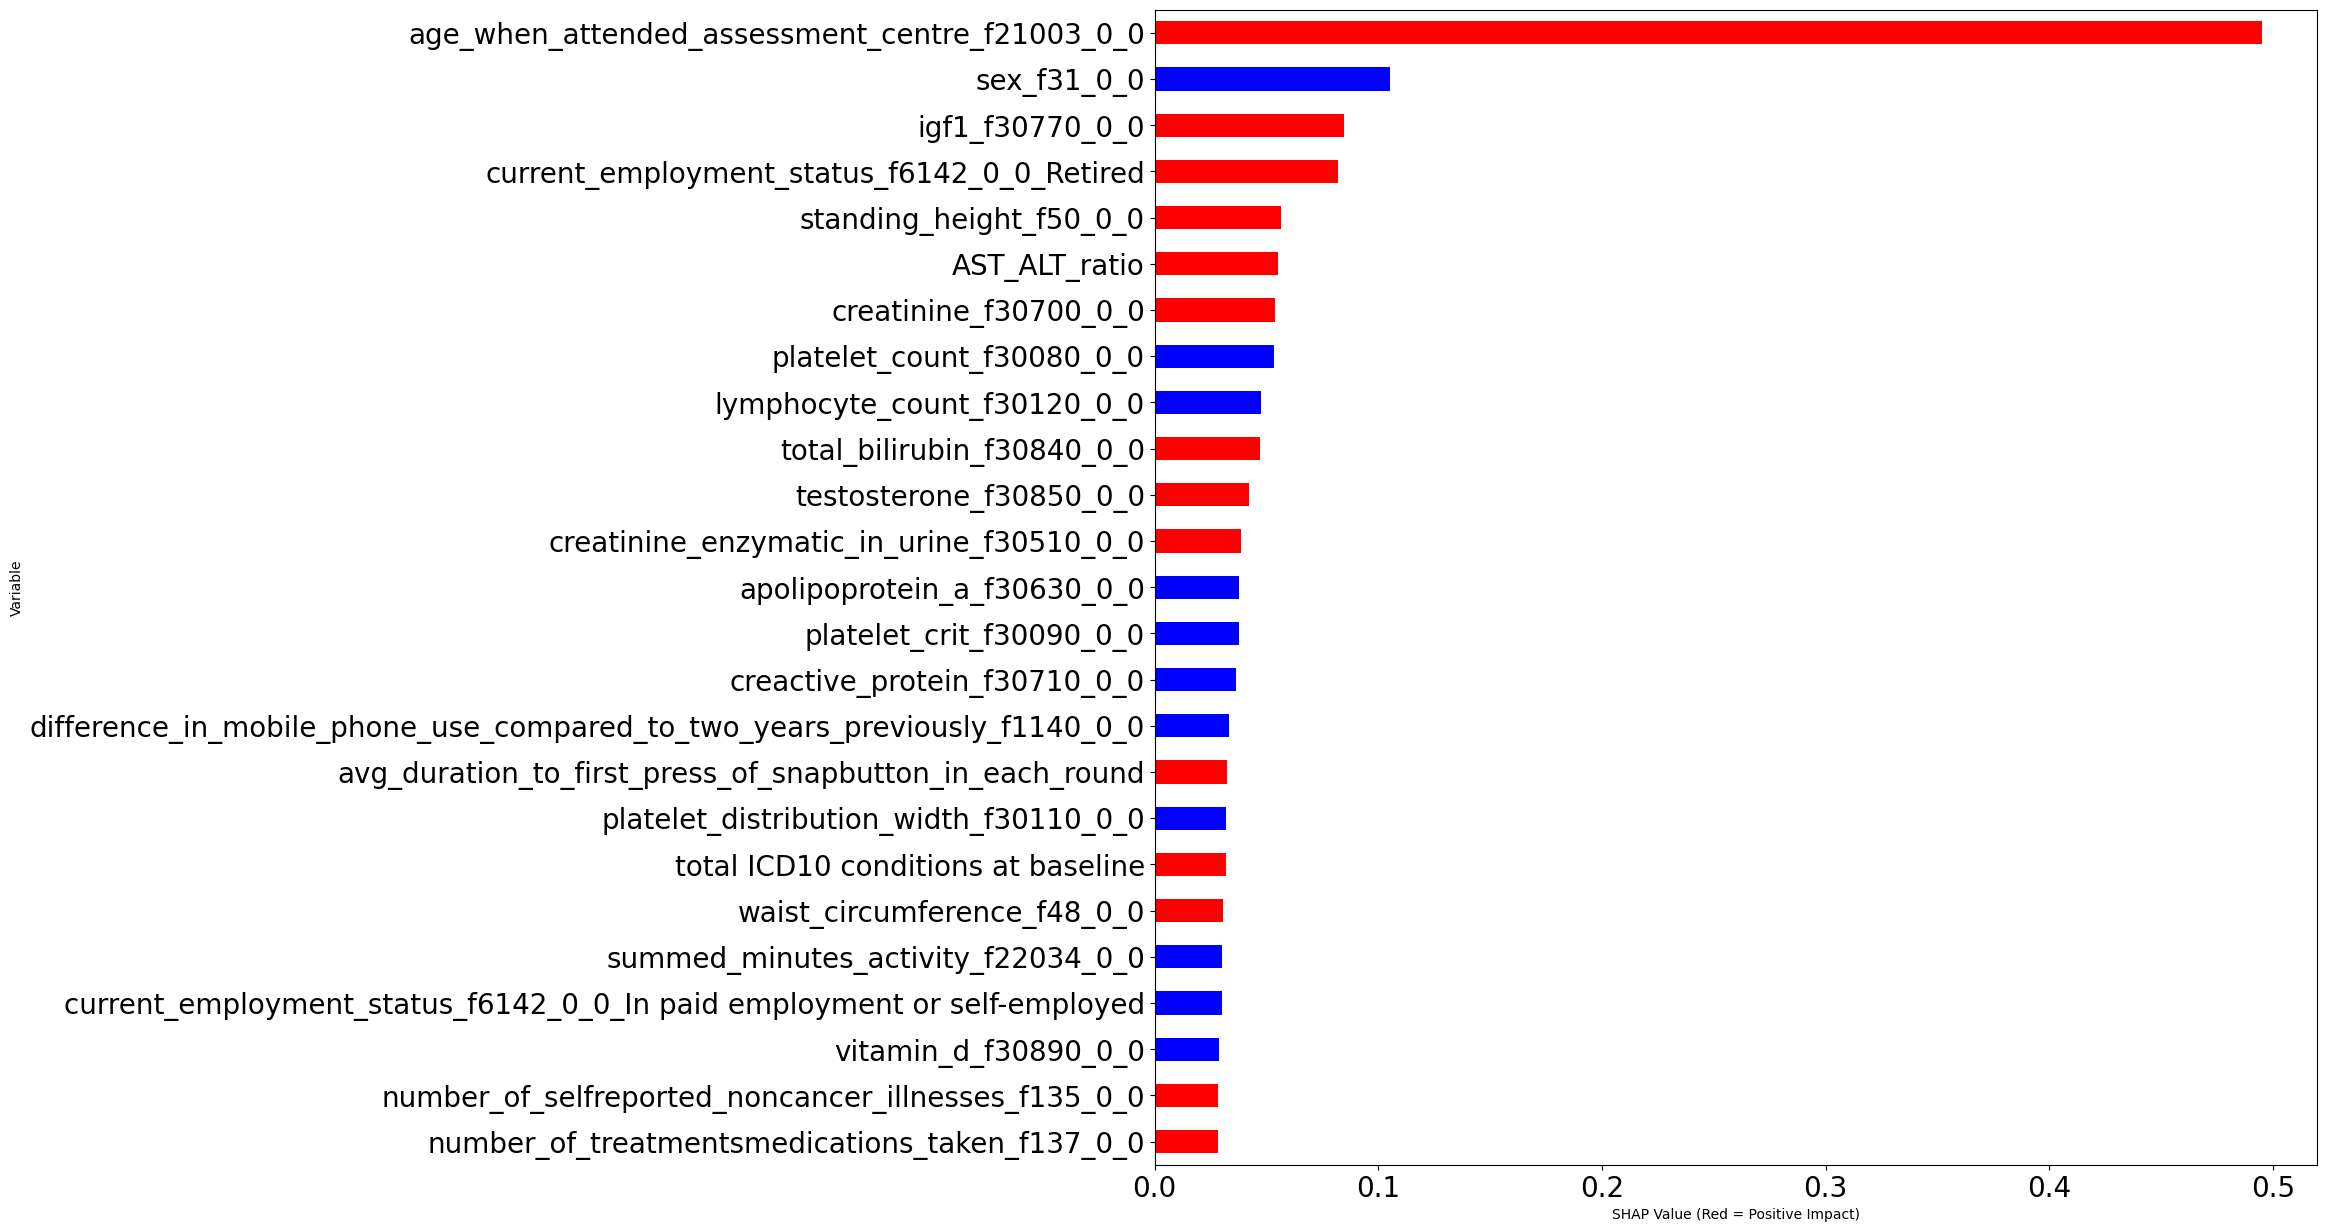

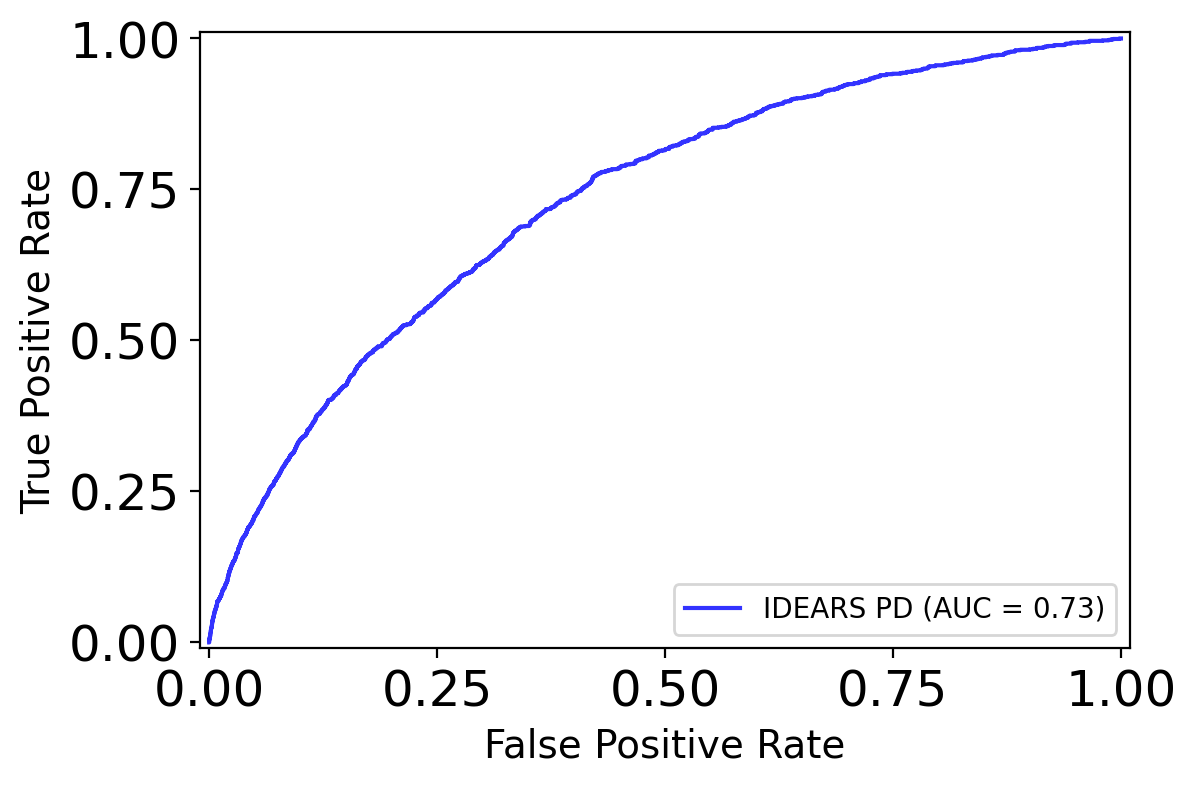

In [5]:
roc=ac.plot_ROCAUC_mult(y_test=[outs_pd[0]['y_test']],
                        y_score=[outs_pd[0]['risk']],
                       labels=['IDEARS PD'],
                       cols=['blue'],
                       figname='PD IDEARS v1')